# Classification analysis (supermarket data)

## Libraries and settings

In [39]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

# Show version of scikit-learn
import sklearn
sklearn.__version__

/workspaces/data_analytics/Week_09


'1.5.1'

## Import supermarket data

In [40]:
# Read and select variables
df_supermarkets = pd.read_csv("supermarkets_data_enriched.csv", sep=",", encoding="utf-8")

# Number of rows and columns
print(df_supermarkets.shape)

# First records
df_supermarkets.head(5)

(3242, 18)


,Unnamed: 0,type,id,lat,lon,brand,shop,addr:city,addr:housenumber,addr:postcode,geometry,index_right,bfs_name,bfs_number,pop,pop_dens,frg_pct,emp
0,0,node,33126515,47.155616,9.037915,Spar,supermarket,NaN,NaN,NaN,POINT (9.0379152 47.1556157),227,Schänis,3315,3876,97.142857,13.054696,1408.0
1,1,node,280130028,47.155492,9.039666,ALDI,supermarket,Schänis,3,8718.0,POINT (9.0396663 47.1554921),227,Schänis,3315,3876,97.142857,13.054696,1408.0
2,2,node,6122906632,47.158959,9.044477,Denner,supermarket,Schänis,14,8718.0,POINT (9.0444769 47.1589589),227,Schänis,3315,3876,97.142857,13.054696,1408.0
3,3,node,9019298862,47.155185,9.038472,Lidl,supermarket,NaN,NaN,NaN,POINT (9.0384722 47.1551854),227,Schänis,3315,3876,97.142857,13.054696,1408.0
4,4,node,36726161,47.226191,8.980329,Migros,supermarket,Uznach,25,8730.0,POINT (8.9803292 47.2261912),1217,Uznach,3339,6489,860.610080,27.862537,3500.0


## Variable description

- id unique supermarket identifier  
- lat latitude  
- lon longitude  
- brand supermarket brand (e.g., Migros, Volg, Spar…)  
- bfs_name municipality name  
- bfs_number municipality ID (BFS number)  
- pop population size  
- pop_dens population density  
- frg_pct percentage of foreigners  
- emp number of employees in the municipality  

## Count and remove missing values

In [41]:
# Count missing values
print(df_supermarkets.isna().sum())

# Remove missing values
df_supermarkets = df_supermarkets.dropna(subset=[
    'lat', 
    'lon', 
    'brand', 
    'bfs_name', 
    'bfs_number', 
    'pop', 
    'pop_dens', 
    'frg_pct', 
    'emp'
])


Unnamed: 0             0
type                   0
id                     0
lat                    0
lon                    0
brand               1233
shop                   0
addr:city           1795
addr:housenumber    1690
addr:postcode       1721
geometry               0
index_right            0
bfs_name               0
bfs_number             0
pop                    0
pop_dens               0
frg_pct                0
emp                   45
dtype: int64


In [42]:
# Keep only relevant columns
df_supermarkets = df_supermarkets[[
    'id',
    'bfs_name',
    'bfs_number',
    'lat',
    'lon',
    'brand',
    'pop',
    'pop_dens',
    'frg_pct',
    'emp'
]]

# Show the cleaned data
df_supermarkets.head()


,id,bfs_name,bfs_number,lat,lon,brand,pop,pop_dens,frg_pct,emp
0,33126515,Schänis,3315,47.155616,9.037915,Spar,3876,97.142857,13.054696,1408.0
1,280130028,Schänis,3315,47.155492,9.039666,ALDI,3876,97.142857,13.054696,1408.0
2,6122906632,Schänis,3315,47.158959,9.044477,Denner,3876,97.142857,13.054696,1408.0
3,9019298862,Schänis,3315,47.155185,9.038472,Lidl,3876,97.142857,13.054696,1408.0
4,36726161,Uznach,3339,47.226191,8.980329,Migros,6489,860.610080,27.862537,3500.0


In [43]:
# Create subset with only Migros and Volg supermarkets
df_sub = df_supermarkets.loc[df_supermarkets['brand'].isin(['Migros', 'Volg'])]

# Check result
df_sub['brand'].value_counts()


brand
Migros    486
Volg      210
Name: count, dtype: int64

## Barchart brand count

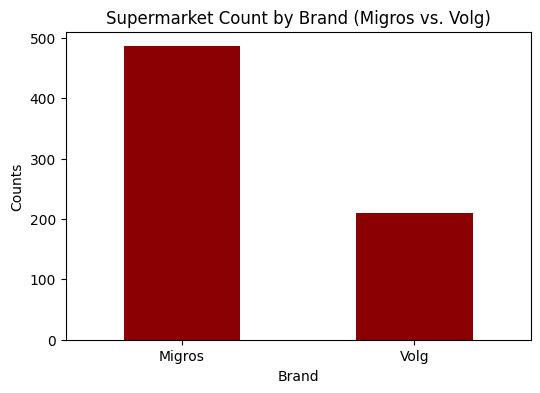

In [44]:
## Barchart brand count (Migros vs. Volg)

# Create a pivot table
table = df_sub[['brand']].pivot_table(
    index='brand',
    aggfunc='size'
)

# Plot bar chart
table.plot(kind='bar',
           ylabel='Counts',
           xlabel='Brand',
           title='Supermarket Count by Brand (Migros vs. Volg)',
           rot=0,
           figsize=(6,4),
           color='darkred')

plt.show()


## Pivot Table for Supermarkets (Migros vs. Volg)

In [45]:
## Pivot table

pd.pivot_table(
    df_sub[['brand', 'pop', 'pop_dens', 'frg_pct', 'emp']],
    index=['brand'],
    values=['pop', 'pop_dens', 'frg_pct', 'emp'],
    aggfunc=(np.mean, 'count')
).round(0)


emp          frg_pct         pop          pop_dens        
       count     mean   count  mean count     mean    count    mean
brand                                                              
Migros   486  60264.0     486  28.0   486  58452.0      486  2016.0
Volg     210   2382.0     210  16.0   210   4811.0      210   363.0

## Classification Tree
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [46]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(
    df_sub[['lat', 'lon', 'pop', 'pop_dens', 'frg_pct', 'emp']],
    df_sub['brand'],
    test_size=0.20,
    random_state=42
)

# Show X_train
print("X_train:")
print(X_train.head(), "\n")

# Show y_train
print("y_train:")
print(y_train.head())


X_train:
            lat       lon     pop      pop_dens    frg_pct       emp
427   46.767777  9.062487    1728     17.891903   8.217593     725.0
271   47.552670  7.592713  173232   7263.396226  37.955459  185432.0
1149  46.203871  6.146234  203951  12810.992462  47.954656  186620.0
2655  46.774599  9.207659    4757     35.638298  16.312802    3229.0
2369  47.126317  7.246363    6872   4521.052632  26.062282    3185.0 

y_train:
427       Volg
271     Migros
1149    Migros
2655    Migros
2369    Migros
Name: brand, dtype: object


### Fit the classification tree model and make predictions

In [47]:
# Initialize the classification tree model 
clf = DecisionTreeClassifier(random_state=20, 
                             max_depth=5)

# Train the classification tree model 
clf = clf.fit(X_train, y_train)

# Make model predictions
y_pred = clf.predict(X_test)
y_pred

array(['Migros', 'Migros', 'Migros', 'Migros', 'Volg', 'Migros', 'Migros',
       'Migros', 'Volg', 'Migros', 'Volg', 'Migros', 'Migros', 'Migros',
       'Migros', 'Volg', 'Volg', 'Volg', 'Volg', 'Volg', 'Volg', 'Migros',
       'Volg', 'Migros', 'Migros', 'Volg', 'Volg', 'Migros', 'Volg',
       'Migros', 'Migros', 'Volg', 'Migros', 'Migros', 'Migros', 'Migros',
       'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Volg',
       'Volg', 'Volg', 'Migros', 'Volg', 'Migros', 'Migros', 'Migros',
       'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Volg',
       'Migros', 'Volg', 'Volg', 'Migros', 'Migros', 'Migros', 'Migros',
       'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros',
       'Migros', 'Migros', 'Volg', 'Migros', 'Migros', 'Volg', 'Migros',
       'Migros', 'Migros', 'Migros', 'Volg', 'Migros', 'Volg', 'Migros',
       'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros',
       'Migros', 'Volg', 'Migros', 'Migros', 'Migros', 'Mig

### Show confusion matrix and classification report

In [48]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred), '\n')

# Classification report
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[97 11]
 [ 6 26]] 

Classification report
              precision    recall  f1-score   support

      Migros       0.94      0.90      0.92       108
        Volg       0.70      0.81      0.75        32

    accuracy                           0.88       140
   macro avg       0.82      0.86      0.84       140
weighted avg       0.89      0.88      0.88       140



### Print text representation of the classification tree

In [49]:
# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)

|--- emp <= 1399.00
|   |--- pop <= 2598.50
|   |   |--- lat <= 46.35
|   |   |   |--- emp <= 512.50
|   |   |   |   |--- emp <= 244.50
|   |   |   |   |   |--- class: Volg
|   |   |   |   |--- emp >  244.50
|   |   |   |   |   |--- class: Migros
|   |   |   |--- emp >  512.50
|   |   |   |   |--- class: Volg
|   |   |--- lat >  46.35
|   |   |   |--- emp <= 824.00
|   |   |   |   |--- class: Volg
|   |   |   |--- emp >  824.00
|   |   |   |   |--- emp <= 856.50
|   |   |   |   |   |--- class: Migros
|   |   |   |   |--- emp >  856.50
|   |   |   |   |   |--- class: Volg
|   |--- pop >  2598.50
|   |   |--- lat <= 46.87
|   |   |   |--- lat <= 46.10
|   |   |   |   |--- class: Volg
|   |   |   |--- lat >  46.10
|   |   |   |   |--- frg_pct <= 30.43
|   |   |   |   |   |--- class: Migros
|   |   |   |   |--- frg_pct >  30.43
|   |   |   |   |   |--- class: Volg
|   |   |--- lat >  46.87
|   |   |   |--- pop_dens <= 750.01
|   |   |   |   |--- pop_dens <= 387.54
|   |   |   |   |   |--- 

## Visualize the classification tree

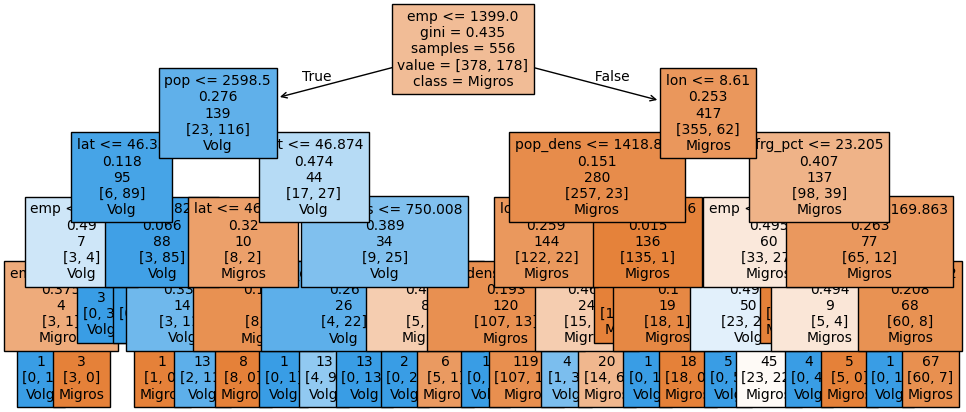

In [50]:
# Visualize the classification tree
fig = plt.figure(figsize=(12,5))
tree_plot = tree.plot_tree(
    clf,
    feature_names=list(X_train.columns),
    class_names=['Migros', 'Volg'],  
    filled=True,
    fontsize=10,
    label='root'
)


## Random Forest Classifier
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [51]:
# Create train and test samples (50% / 50% split)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    df_sub[['pop_dens', 'emp']],  
    df_sub['brand'],              
    test_size=0.50,
    random_state=42
)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())


X2_train:
         pop_dens       emp
293   7263.396226  185432.0
2568   155.712707    3100.0
1175   739.569314   13035.0
1436   545.755396    3713.0
57    4778.994655  491193.0 

y2_train:
293     Migros
2568    Migros
1175    Migros
1436    Migros
57      Migros
Name: brand, dtype: object


### Fit the Random Forest Classifier

In [52]:
# Initialize the random forest classifier
rfc = RandomForestClassifier(random_state=20, max_depth=10)

# Train the random forest classifier
rfc = rfc.fit(X2_train, y2_train)

# Predict the target variable ('Migros' / 'Volg')
y_pred_rf = rfc.predict(X2_test)

print('Predicted brand (Migros / Volg):')
y_pred_rf


Predicted brand (Migros / Volg):


array(['Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Volg',
       'Migros', 'Volg', 'Migros', 'Volg', 'Migros', 'Migros', 'Migros',
       'Migros', 'Volg', 'Volg', 'Volg', 'Volg', 'Volg', 'Volg', 'Migros',
       'Volg', 'Migros', 'Migros', 'Volg', 'Volg', 'Migros', 'Volg',
       'Migros', 'Migros', 'Volg', 'Migros', 'Migros', 'Migros', 'Migros',
       'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Volg',
       'Volg', 'Volg', 'Migros', 'Volg', 'Migros', 'Migros', 'Migros',
       'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Volg',
       'Migros', 'Volg', 'Volg', 'Migros', 'Volg', 'Migros', 'Migros',
       'Migros', 'Volg', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros',
       'Migros', 'Volg', 'Migros', 'Migros', 'Volg', 'Migros', 'Volg',
       'Migros', 'Volg', 'Volg', 'Migros', 'Volg', 'Migros', 'Migros',
       'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Migros', 'Volg',
       'Migros', 'Migros', 'Migros', 'Migros', 'M

### Show confusion matrix and classification report

In [53]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y2_test, y_pred_rf), '\n')

# Classification report
print('Classification report')
print(classification_report(y2_test, y_pred_rf))

Confusion matrix
[[216  30]
 [ 28  74]] 

Classification report
              precision    recall  f1-score   support

      Migros       0.89      0.88      0.88       246
        Volg       0.71      0.73      0.72       102

    accuracy                           0.83       348
   macro avg       0.80      0.80      0.80       348
weighted avg       0.83      0.83      0.83       348



### Show feature importance

Features sorted by importance:
Index(['emp', 'pop_dens'], dtype='object')
[0.6013466 0.3986534]


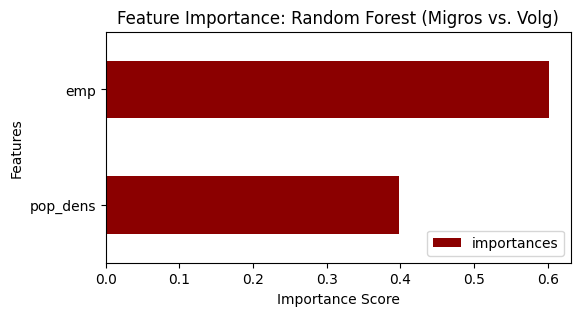

In [54]:
# Feature names
cols = X2_train.columns

# Derive feature importance from random forest
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print feature names and importance values
print("Features sorted by importance:")
print(cols[indices])
print(importances[indices])

# Barplot with feature importance
df_fi = pd.DataFrame({'features': cols, 'importances': importances})
df_fi.sort_values('importances', inplace=True)

df_fi.plot(kind='barh',
           y='importances',
           x='features',
           color='darkred',
           figsize=(6,3))

plt.title("Feature Importance: Random Forest (Migros vs. Volg)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


### ROC curve and AUC

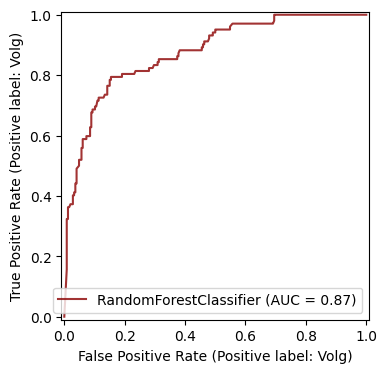

In [55]:
# Plot ROC curve and calculate AUC
plt.figure(figsize=(6,4))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, 
                                          X2_test, 
                                          y2_test, 
                                          ax=ax,
                                          alpha=0.8,
                                          c="darkred")
plt.show()



### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [56]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-12-03 19:16:44
Python Version: 3.11.14
-----------------------------------
